## Deep learning prototype model
Tensorflow implementation of a fully connected deep net for arbitrarily shaped input and output layers, with the following features:
- Easy control of net topology and hyperparameters
- Abstracted functions for retrieving/constructing training data
- Exponential decay of learning rate
- Dropout regularisation
- Batch normalisation
- Automatic logging of bulk statistics of each layer through tensorboard (and convenient functions to attach logging to custom functions)


## Visualising progress
To inspect the training progress, run

>  `>tensorboard --logdir=<log_dir>`


from the terminal, where `log_dir` as as defined above

## Requirements
- TensorFlow 1.8
- numpy
- subprocess


In [2]:
import tensorflow as tf
import numpy as np
from subprocess import call
import time, math
import h5py
import shutil

In [132]:
# Setting dtype for tensorflow and numpy environments
DTYPE = tf.float64
DTYPE_np = np.float64
log_dir = '/mnt/dataDrive3/mahasen/tmp/funclearn' # Directory where we dump tensorboard log files

# Useful function for resetting logdir and tensorflow graph
def reset_tf():
    call(["rm","-rf",log_dir+'/'])
    tf.reset_default_graph()
    
    
# Define some functions for initialising layers with appropriate statistics    
def get_weights(shape,dtype):
    # Returns trainable weight variable, initialised from truncated (+\- 2std. dev. only) standard normal distribution
    return tf.Variable(tf.truncated_normal(shape, dtype=dtype),name='weights')

def get_biases(shape,dtype):
    # Returns trainable bias variable, initialised arbitrarily as a small constant
    return tf.Variable(tf.constant(0.01, shape=shape, dtype=dtype),name='biases')

def get_bn_offset(shape,dtype):
    # Returns trainable bias/offset variable for batch normalisation
    return tf.Variable(tf.truncated_normal(shape=shape, dtype=dtype),name='beta_offset')

def get_bn_scale(shape,dtype):
    # Returns trainable scale variable for batch normalisation
    return tf.Variable(tf.constant(1.0, shape=shape, dtype=dtype),name='gamma_scale')


def variable_summaries(var):
    # Attaches mean, stddev, max, min, and a histogram of an input var to a tensor
    # Useful for TensorBoard visualisation
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var,name='mean')
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var-mean)),name='stddev')
        
        tf.summary.scalar('mean',mean)
        tf.summary.scalar('stddev',stddev)
        tf.summary.scalar('max',tf.reduce_max(var))
        tf.summary.scalar('min',tf.reduce_min(var))
        tf.summary.histogram('histogram', var)
        
def batchnorm(logits, is_test, offset, scale, iteration):
    # Get summary statistics of this batch
    mean, variance    = tf.nn.moments(logits, [0],name='moments')
    
    # We'll use an exponential moving average over the training iterations during test time
    # This is a tool to do that
    exp_moving_avg    = tf.train.ExponentialMovingAverage(0.9999, iteration)
    update_moving_avg = exp_moving_avg.apply([mean, variance])
    
    # If this is the test, we use the m,v values we obtained from the exponential moving average 
    # over mean, variance that we obtained from training. otherwise use the batch mean, variance
    mean_cond        = tf.cond(is_test, lambda: exp_moving_avg.average(mean), lambda: mean, name='mean_cond')
    variance_cond    = tf.cond(is_test, lambda: exp_moving_avg.average(variance), lambda: variance, name='variance_cond')
    
    # This applies the following normalisation: x-> scale*(x-mean(x))/(variance_epsilon+std(x)) + offset
    logits_bn = tf.nn.batch_normalization(logits, mean_cond, variance_cond, offset, scale, variance_epsilon=1e-5,name='logits_batchnormed')
    
    return logits_bn, update_moving_avg

def get_layer_complete(input_tensor,input_dim, output_dim, layer_name, is_test, prob_keep, global_step, act_func=tf.nn.relu):
    with tf.name_scope(layer_name):
        with tf.name_scope('weights'):
            weights = get_weights([input_dim, output_dim],DTYPE)
            variable_summaries(weights)
        #with tf.name_scope('biases'):
        #    biases = get_biases([output_dim],DTYPE)
        #    variable_summaries(biases)
        with tf.name_scope('batchnorm'):
            offset = get_bn_offset([output_dim], DTYPE)
            scale  = get_bn_scale([output_dim], DTYPE)
        
        #logits = tf.add(tf.matmul(input_tensor, weights),biases,name='logits')
        logits = tf.matmul(input_tensor, weights,name='logits') # don't need biases if we're using batch norms
        tf.summary.histogram('logits', logits)
        logits_bn, update_moving_avg = batchnorm(logits, is_test, offset, scale, global_step)
        tf.summary.histogram('logits_batchNormed', logits_bn)
        activated = act_func(logits_bn, name='activation')
        dropped_out = tf.nn.dropout(activated,prob_keep,name='dropout')
        tf.summary.histogram('activations', activated)
        return dropped_out, update_moving_avg 
    
def func_deep_learner_complete(x,m,n,h,is_test,global_step,prob_keep,act_func=tf.nn.relu,num_layers=5):
    # x is the input variable, probably a TensorFlow placeholder object
    # m is the input dimension
    # n is the output dimension
    # h is the number of hidden neurons
    # act_func is the activation function to be applied
    # is_test is a flag is use to control batch normalisation behaviour during inferene on test data
    # iteration is the iteration counter used inside the training loop; required for batch normalisation
    
    bn_moving_avg_updates = []

    with tf.variable_scope('func_learner'):
        # 0th hidden layer
        hidden_layer, update_moving_avg = get_layer_complete(x,m,h,'hidden_layer_0',is_test,prob_keep,global_step)
        bn_moving_avg_updates.append(update_moving_avg)

        # Other hidden layers
        for i in range(num_layers-1):
            hidden_layer, update_moving_avg = get_layer_complete(hidden_layer,h,h,'hidden_layer_'+str(i+1),is_test,prob_keep,global_step)
            bn_moving_avg_updates.append(update_moving_avg)

        # Output layer
        weights1= tf.get_variable(name='output_layer_weights',
                              shape=[h,n],
                              initializer=tf.random_normal_initializer(),
                              dtype=DTYPE)

    return tf.matmul(hidden_layer,weights1), bn_moving_avg_updates



## Theory

Consider a Mach-Zehnder interferometer with interrogation time $T$ and pulse duration $\tau$. The total interferometer phase is given by:
$$\Delta\Phi = \phi_{eff}^1 - 2\phi_{eff}^2 + \phi_{eff}^3 + \left(\mathrm{arg}(\Theta_0^1)-\mathrm{arg}(\Theta^3_0)\right)$$
where $\phi_{eff}^i$ describes the "light phase at the atomic positions during the three Raman pulses". $\Theta_0^i$ descibes secondary phase shifts due to "different light shifts between the first and last pulse".

Define the sensitivity function $g(t)$ as the effect on the total interferometer phase due to a phase jump $\delta\phi$ at time $t$. For the three-pulse Mach-Zehnder, with second pulse centered at $t=0$, $g(t)$ is given by:
$$g(t) = \begin{cases}
\sin(\Omega_rt), & 0<t\leq\tau \\
1, & \tau<t\leq T+\tau\\
-\sin(\Omega_r(T-t)), & T+\tau<t\leq T+2\tau \\
0, & t>T+2\tau
\end{cases}$$

For finite Raman pulse duration (i.e. $\tau>0$), the total interferometer phase is given by:
$$\Delta\Phi = \int_{-(T_2\tau)}^{(T+2\tau)}g(t)\frac{d\phi(t)}{dt}dt$$

To perform post-correction, we separtely calculate the phase offset caused by mirror vibrations:
$$\Phi_{vib} = k_{eff}\int_{t_1}^{t_3}g(t)v(t)dt$$
where $v(t)=\frac{1}{k_{eff}}\frac{d\phi}{dt}$ is the mirror velocity and $k_eff$ is the effective wavevector

## Data layout
Data is organised into campaigns, each containing ~10^5 interferometer runs. Use only 4a onwards.
Each `.h5` has three fields
- `accelerometer`: `[N_a,2]` linearly proportional to the raw out from the accelerometer as a time series. 1st column is linux time, 2nd column is signal
- `ai_kdown`: `[N_p,2]` total interferometer phase for kdown? configuration. 1st column is linux time, 2nd column is phase. Each row is the total interferometer phase for an Mach-Zehnder sequence with 2nd pulse centered at the given time
- `ai_kup`: `[N_p,2]` total interferometer phase for kup? configuration. Same layout as `ai_kdown`
- `(T,tau)`: `[2,]` the interferometer interrogation time `T` and the $\frac{\pi}{2}$ Raman pulse duration `tau`

First we need to prepare the data.

(1) Check timestamps of `ai_kdown`==`ai_kup`
- THEY DON'T; they aren't even necessarily the same length. Assume that each corresponds to a completely different subsequence of `accelerometer`
- Also, note that the distribution of delays between successive runs is weirdly distributed

(2) For each ai_* associate a contiguous subsequence of `accelerometer`
 - Ensure each subsequence is of equal length `N_s`
 - Will being left/right aligned w.r.t. rounding of `ai_kdown` timestamp to `accelerometer` timestamps affect anything?
 - Safest thing to do might be linearly interpolate `accelerometer` to ensure that `accelerometer` subsequence is correctly time-aligned with `ai_*`
 
(3) Construct our inputs and outputs
 - `x_input` = `[N_s,N_p]` array
 - `y_output` = `[N_p,2]` concatenate 2nd column of `ai_kdown` and `ai_kup`
    
## Check
Make sure we can reproduce original data (i.e. reproduce original $\Phi_{vib}$)
 - Do we have this data?
    
## Modelling
(1) *Model-free* Just use the inputs and labels as they are (assuming `N_s` is small enough)
 - Pros: easy
 - Cons: no ground-truth to compare against

(2) *Explicit transfer function* Apply unknown function in Laplace space ($\mathcal{L}\{y(t)\}(Z) =H(Z)\mathcal{L}\{x(t)\}(Z)$ )
 - Pros: ground-truth to compare against
 - Cons: less easy
    

## Use Processed campaign4a
Matlab used to assign subsequences in `accelerometer` to each entry in `ai_kup` and `ai_kdown`.
Subsequence length is 195. ~100000 entries for each of `ai_kup` and `ai_kdown`.

In [133]:
# Let's define a function that will generate indices for batches
# accounting for the possibility that the size of the dataset
# will not be an even multiple of the batch size
def generate_batches(N,batch_size=32):
    # N is the number of elements in the dataset
    if N<batch_size:
        raise ValueError('batch_size must be smaller than N')
    perm = np.random.permutation(N);
    if np.mod(N,batch_size)!=0:
        # We need to append to perm so that is is an even multiple of batch_size
        perm2= np.random.permutation(N);
        perm = np.concatenate((perm,perm2[0:batch_size-np.mod(N,batch_size)]))
    
    n_batches = np.int(len(perm)/batch_size)
    batches = perm.reshape(batch_size,n_batches)
    
    return batches

def get_xy_by_inds(x,y,inds):
    # Get values from 2Dx, 1Dy arrays
    x0 = x[inds,:]
    y0 = np.array(list(map(y.__getitem__,inds))) # because Python treats 1D arrays differently from ND arrays
    y0 = y0.reshape([len(y0),1])
    return x0,y0
    
def generate_testtrain(x,y,test_fraction,batch_size=32):
    # Assumes x.shape = [n_samples,input_size], y.shape = [input_size,]
    if test_fraction<0 or test_fraction>1:
        raise ValueError('test_fraction must be between 0 and 1')
    
    n_samples  = x.shape[0]
    test_size  = np.int(np.round(n_samples*test_fraction))
    if test_size<1:
        raise ValueError('test_fraction is too small')
    train_size = np.int(n_samples-test_size)
    
    # Permute x,y
    perm = np.random.permutation(n_samples)
    permi= np.argsort(perm)
    x0,y0= get_xy_by_inds(x,y,permi)
                    
    train_x = x0[:train_size,:]
    train_y = y0[:train_size,:]
    
    test_x  = x0[train_size:,:]
    test_y  = y0[train_size:,:]
    
    batches = generate_batches(train_size,batch_size)
    
    return test_x,test_y,train_x,train_y,batches

def generate_groundtruthtest(x,y,ground_truth_frac,ground_truth_periods):
    # Separate input data into (x,y) pairs for training and (x,y) pairs for ground truth testing
    if ground_truth_frac<0 or ground_truth_frac>1:
        raise ValueError('test_fraction must be between 0 and 1')
    n_samples  = x.shape[0]
    test_size  = np.int(np.round(n_samples*ground_truth_frac/ground_truth_periods))
    if test_size<1:
        raise ValueError('test_fraction is too small')
        
    n_samples_per_period = np.int(np.round(n_samples/ground_truth_periods))
    n_test_samples_per_period = np.int(np.round(n_samples_per_period*ground_truth_frac))
    n_train_samples_per_period = np.int(np.round(n_samples_per_period - n_test_samples_per_period))
                                        
    train_inds = np.array([])
    test_inds = np.array([])
    counter = 0
    
    for i in range(ground_truth_periods):
        if i!=(ground_truth_periods-1):
            test_inds = np.concatenate([test_inds,list(range(counter,counter+n_test_samples_per_period))])
            counter += n_test_samples_per_period
            train_inds = np.concatenate([train_inds,list(range(counter,counter+n_train_samples_per_period))])
            counter += n_train_samples_per_period
        else:
            # Assume n_samples>>ground_truth_periods
            test_inds = np.concatenate([test_inds,list(range(counter,counter+n_test_samples_per_period))])
            counter += n_test_samples_per_period
            train_inds = np.concatenate([train_inds,list(range(counter,n_samples))])
            counter += (n_samples-counter)
    test_inds = [np.int(i) for i in test_inds]
    train_inds = [np.int(i) for i in train_inds]
    
    train_x,train_y   = get_xy_by_inds(x,y,train_inds)
    test_x,test_y     = get_xy_by_inds(x,y,test_inds)    
    
    return test_inds,test_x,test_y,train_inds,train_x,train_y
    

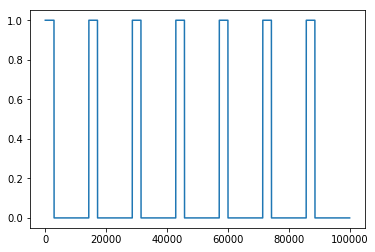

In [119]:
x = np.array(list(range(0,100000)))
y = np.zeros(100000)
test_inds,train_inds= generate_groundtruthtest(x,y,0.2,7)

import matplotlib.pyplot as plt
test_sign = np.zeros(100000)
for i in test_inds:
    test_sign[i] = 1
    
plt.plot(x,test_sign)
plt.show()

In [5]:
def func_deep_learner_arbshape(x,m,n,h,is_test,global_step,prob_keep,act_func=tf.nn.relu):
    # x is the input variable, probably a TensorFlow placeholder object
    # m is the input dimension
    # n is the output dimension
    # h is a LIST of hidden neurons
    # act_func is the activation function to be applied
    # is_test is a flag is use to control batch normalisation behaviour during inferene on test data
    # iteration is the iteration counter used inside the training loop; required for batch normalisation
    
    num_layers = len(h)
    
    bn_moving_avg_updates = []

    with tf.variable_scope('func_learner'):
        # 0th hidden layer
        hidden_layer, update_moving_avg = get_layer_complete(x,m,h[0],'hidden_layer_0',is_test,prob_keep,global_step)
        bn_moving_avg_updates.append(update_moving_avg)

        # Other hidden layers
        for i in range(num_layers-1):
            hidden_layer, update_moving_avg = get_layer_complete(hidden_layer,h[i],h[i+1],'hidden_layer_'+str(i+1),is_test,prob_keep,global_step)
            bn_moving_avg_updates.append(update_moving_avg)

        # Output layer
        weights1= tf.get_variable(name='output_layer_weights',
                              shape=[h[-1],n],
                              initializer=tf.random_normal_initializer(),
                              dtype=DTYPE)

    return tf.matmul(hidden_layer,weights1), bn_moving_avg_updates

In [145]:
def train_RBM_complete_mccv(input_size=1,output_size=1,hidden_sizes=[5,5],x_data=None,y_data=None,
                  batch_size=32, epochs =5, test_fraction=0.1, test_interval=250, initial_learning_rate = 0.02,
                  epoch_learning_rate_decay = 0.5, epoch_learning_rate_interval = 10,
                  sgd_switch_epoch = 3,prob_keep = 0.8,
                  ground_truth_frac=0.2, ground_truth_periods = 7,
                  fname_model_out='/tmp/model.ckpt',
                  fname_data_out='/tmp/model_data.pkl'):
    # Using montecarlo crossvalidation
    config = tf.ConfigProto(
        device_count = {'GPU': 1}
    )
    
    with tf.Session(config=config) as sess:
        
        # Separate data into ground truth test and train data
        ground_truth_test_inds,ground_truth_test_x,ground_truth_test_y,ground_truth_train_inds,ground_truth_train_x,ground_truth_train_y = generate_groundtruthtest(x_data,y_data,ground_truth_frac,ground_truth_periods)
        
        # Generate test data initially for convenience
        test_x,test_y,train_x_full,train_y_full,batches = generate_testtrain(ground_truth_train_x,ground_truth_train_y,test_fraction,batch_size)
        n_samples = len(y_data)
        max_steps = batches.shape[1]
            
        with tf.name_scope('input'):
            # Placeholder variables which will be fed data at train time
            x  = tf.placeholder(DTYPE,[None,input_size],name='x_input')
            y  = tf.placeholder(DTYPE,[None,output_size],name='y_input')
        
        with tf.name_scope('control_inputs'):
            global_step = tf.Variable(0, trainable=False,name='global_step')
            epoch_ind = tf.Variable(0,trainable=False,name='epoch_ind')
            increment_epoch_ind = tf.assign_add(epoch_ind,1,name='increment_epoch_ind')
            is_test = tf.contrib.eager.Variable(False, trainable=False,name='is_test')

        # Predictions of the NN
        y_pred, bn_moving_avg_updates = func_deep_learner_arbshape(x,input_size,output_size,hidden_sizes,is_test,global_step,1)

        with tf.name_scope('mean_squared_error'):
            mse = tf.losses.mean_squared_error(y,y_pred)
        tf.summary.scalar('mean_squared_error',mse)

        with tf.name_scope('train'):
            global_step_in_epoch = global_step - epoch_ind*max_steps
            #learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step_in_epoch, decay_steps, decay_rate, staircase=True)
            learning_rate = tf.train.exponential_decay(initial_learning_rate, epoch_ind, epoch_learning_rate_interval, epoch_learning_rate_decay, staircase=True)
            tf.summary.scalar('learning_rate', learning_rate)
            train_step      = tf.train.AdamOptimizer(learning_rate).minimize(mse, global_step = global_step)
            #train_step = tf.train.MomentumOptimizer(learning_rate,0.9,use_nesterov=True).minimize(mse, global_step = global_step)
            train_step_sgd = tf.train.MomentumOptimizer(learning_rate,0.9,use_nesterov=True).minimize(mse, global_step = global_step)

        # Create merged summary object and file writers
        merged_summaries = tf.summary.merge_all()
        train_writer = tf.summary.FileWriter(log_dir + '/train', sess.graph)
        test_writer = tf.summary.FileWriter(log_dir + '/test', sess.graph)
        ground_truthtest_writer = tf.summary.FileWriter(log_dir + '/ground_truth_test', sess.graph)
        
        # Add ops to save and restore all the variables.
        saver = tf.train.Saver()

        
        # Initialise variables
        sess.run(tf.global_variables_initializer())
        
        # Train the model
        start_time = time.time()
        old_time = start_time
        for j in range(epochs):
            # At each epoch, regenerate test data, train data, and batches
            test_x,test_y,train_x_full,train_y_full,batches = generate_testtrain(x_data,y_data,test_fraction,batch_size)
            n_batches = batches.shape[1]
            n_test = len(test_y)
            epoch_init_time = time.time()
                
            print('Starting Epoch %d, with %d batches' % (j,max_steps))
            for i in range(n_batches):
                if i % test_interval ==0:
                    # Check how our model performs against the epoch test data
                    [summary, mse_val] = sess.run([merged_summaries,mse], feed_dict={x: ground_truth_test_x, y: ground_truth_test_y, is_test: True})
                    test_writer.add_summary(summary,i + j*max_steps)
                    
                    # Check how our model performs against the ground truth test data
                    [summary, ground_mse_val] = sess.run([merged_summaries,mse], feed_dict={x: test_x, y: test_y, is_test: True})
                    ground_truthtest_writer.add_summary(summary,i + j*max_steps)
                    curr_time = time.time()
                    print('\tEpoch %d, Step %04d, MSE: %4.3e, Ground truth MSE: %4.3e,  LearnRate: %4.3e, Time taken : %4.3fs' % (sess.run(epoch_ind),i, mse_val,ground_mse_val, sess.run(learning_rate),curr_time-old_time))
                    old_time = curr_time
                else:
                    # Generate new sample data and train our model
                    train_x, train_y = get_xy_by_inds(train_x_full,train_y_full,batches[:,i])
                    if (np.mod(j,epoch_learning_rate_interval)<sgd_switch_epoch):
                        summary, _ = sess.run([merged_summaries, train_step], feed_dict={x: train_x, y: train_y, is_test: False})
                    else:
                        summary, _ = sess.run([merged_summaries, train_step_sgd], feed_dict={x: train_x, y: train_y, is_test: False})
                    sess.run(bn_moving_avg_updates, feed_dict={x: train_x, y: train_y, is_test: False})
                    train_writer.add_summary(summary,i+ j*max_steps)
            # End of epoch, calculate avg stats
            epoch_end_time = time.time()
            sess.run(increment_epoch_ind)
            avg_mrad = np.sqrt(mse_val)*1000
            print('Epoch %d time: %4.3fs, average error = %4.3fmrad' % (j,epoch_end_time-epoch_init_time,avg_mrad))
        train_writer.close()
        test_writer.close()  
        ground_truthtest_writer.close()
        print('\nTotal time:\t %4.3fs' % (time.time()-start_time))
        
        # Save model
        save_path = saver.save(sess, fname_model_out)
        print("Model saved in path: %s" % save_path)
        
        # Save parameters, data
        with h5py.File(fname_data_out,'w') as file:
            file.create_dataset('/ground_truth_test_inds', data=ground_truth_test_inds)
            file.create_dataset('/ground_truth_train_inds', data=ground_truth_train_inds)

In [135]:
def train_RBM_complete_mccv_inference(input_size=1,output_size=1,hidden_sizes=[5,5],x_data=None,y_data=None,
                  fname_model_in='/tmp/model.ckpt'):
    # Using montecarlo crossvalidation
    config = tf.ConfigProto(
        device_count = {'GPU': 0}
    )
    
    with tf.Session(config=config) as sess:

            
        with tf.name_scope('input'):
            # Placeholder variables which will be fed data at train time
            x  = tf.placeholder(DTYPE,[None,input_size],name='x_input')
            y  = tf.placeholder(DTYPE,[None,output_size],name='y_input')
        
        with tf.name_scope('control_inputs'):
            global_step = tf.Variable(0, trainable=False,name='global_step')
            epoch_ind = tf.Variable(0,trainable=False,name='epoch_ind')
            increment_epoch_ind = tf.assign_add(epoch_ind,1,name='increment_epoch_ind')
            is_test = tf.contrib.eager.Variable(False, trainable=False,name='is_test')

        # Predictions of the NN
        y_pred, bn_moving_avg_updates = func_deep_learner_arbshape(x,input_size,output_size,hidden_sizes,is_test,global_step,1)
        
        # Restore all the variables.
        saver = tf.train.Saver()
        saver.restore(sess,  fname_model_in)
        
        # Run inference
        predicted_values = sess.run(y_pred, feed_dict={x: x_data, is_test: False})
    return predicted_values

In [142]:
def train_model(acc,phase,fname_model_out='',fname_data_out=''):
    n_samples  = acc.shape[0]
    seq_length = acc.shape[1]
    
    input_size  = seq_length
    output_size = 1
    
    hidden_sizes = [256,128,96,64,32,16,8]
    batch_size  = 768
    
    mccv_steps   = 5000
    test_fraction= 0.1
    
    # sgd_switch_epoch now means that if mod(epoch_ind,epoch_learning_rate_interval)>sgd_switch_epoch, then SGD is used
    train_RBM_complete_mccv(input_size=input_size,output_size=output_size,hidden_sizes=hidden_sizes,initial_learning_rate=0.1,
                            x_data=acc,y_data=phase,batch_size=batch_size, epochs=mccv_steps,test_fraction=test_fraction,test_interval=50,
                            epoch_learning_rate_decay = 0.5, epoch_learning_rate_interval = 1000,sgd_switch_epoch = 750,
                            prob_keep = 0.6,ground_truth_frac=0.2, ground_truth_periods = 7,fname_model_out=fname_model_out,fname_data_out=fname_data_out)

In [138]:
def run_model(acc,phase,fname):
    n_samples  = acc.shape[0]
    seq_length = acc.shape[1]
    
    input_size  = seq_length
    output_size = 1
    
    hidden_sizes = [256,128,96,64,32,16,8]
    
    preds = train_RBM_complete_mccv_inference(input_size=input_size,output_size=output_size,hidden_sizes=hidden_sizes,
                            x_data=acc,y_data=phase,fname_model_in=fname)
    
    return preds

In [139]:
fname_in = './ChrisFreierPhDCampaigns/campaign4_proc.h5'
fname_out = './ChrisFreierPhDCampaigns/campaign4_proc_preds_up_and_down.h5'

In [14]:
with h5py.File(fname_in,'r') as f0:
    dset_up = f0['/ai_kup']
    dset_down = f0['/ai_kdown']
    
    ai_kup_phase = np.array(list(dset_up['phase']))
    ai_kup_acc = np.array(list(dset_up['acc']))
    ai_kup_timestamp = np.array(list(dset_up['timestamp']))

    ai_kdown_phase = np.array(list(dset_down['phase']))
    ai_kdown_acc = np.array(list(dset_down['acc']))
    ai_kdown_timestamp = np.array(list(dset_down['timestamp']))

In [56]:
# Run inference
reset_tf()
preds_up= run_model_ai_kup(ai_kup_acc,ai_kup_phase,'./model_SGD_Nesterov_2.ckpt')
reset_tf()
preds_down= run_model_ai_kup(ai_kdown_acc,ai_kdown_phase,'./model_SGD_Nesterov_2_kdown.ckpt')

INFO:tensorflow:Restoring parameters from ./model_SGD_Nesterov_2.ckpt
INFO:tensorflow:Restoring parameters from ./model_SGD_Nesterov_2_kdown.ckpt


In [52]:
shutil.copy(fname_in,fname_out)

'./ChrisFreierPhDCampaigns/campaign4_proc_preds_up_and_down.h5'

In [58]:
# Write to file
with h5py.File(fname_out,'a') as file:
    file.create_dataset('/ai_kup/preds', data=preds_up.reshape(len(preds_up)), dtype='float64')
    file.create_dataset('/ai_kdown/preds', data=preds_down.reshape(len(preds_down)), dtype='float64')

In [43]:
with h5py.File('./campaign4a_proc_trunc_preds_up_and_down.h5','a') as file:
    print(list(file.items()))
    print(list(file['/ai_kup'].items()))

[('T', <HDF5 dataset "T": shape (1,), type "<f8">), ('ai_kdown', <HDF5 group "/ai_kdown" (5 members)>), ('ai_kup', <HDF5 group "/ai_kup" (5 members)>), ('tau', <HDF5 dataset "tau": shape (1,), type "<f8">)]
[('acc', <HDF5 dataset "acc": shape (90660, 195), type "<f8">), ('avg_30min', <HDF5 dataset "avg_30min": shape (90660,), type "<f8">), ('phase', <HDF5 dataset "phase": shape (90660,), type "<f8">), ('preds', <HDF5 dataset "preds": shape (90660,), type "<f8">), ('timestamp', <HDF5 dataset "timestamp": shape (90660,), type "<f8">)]


In [79]:
data_out = np.concatenate((ai_kup_timestamp,ai_kup_phase,preds),axis=1)
np.savetxt('61mrad.txt',data_out, delimiter=",")
h5out = h5py.File('61mrad.h5','w')
h5out.create_dataset('ai_kup_phase',data=ai_kup_phase)
h5out.create_dataset('ai_kup_timestamp',data=ai_kup_timestamp)
h5out.create_dataset('ai_kup_predictions',data=preds)
h5out.close()

https://arxiv.org/abs/1712.07628

In [146]:
reset_tf()

In [ ]:
train_model(ai_kup_acc,ai_kup_phase,fname_model_out='./model_ground_truth_0.ckpt',fname_data_out='./model_ground_truth_0_data.h5')

Starting Epoch 0, with 156 batches
	Epoch 0, Step 0000, MSE: 7.881e+00, Ground truth MSW: 7.912e+00,  LearnRate: 1.000e-01, Time taken : 2.431s
	Epoch 0, Step 0050, MSE: 3.279e-02, Ground truth MSW: 3.381e-02,  LearnRate: 1.000e-01, Time taken : 5.810s
	Epoch 0, Step 0100, MSE: 3.029e-02, Ground truth MSW: 3.101e-02,  LearnRate: 1.000e-01, Time taken : 3.894s
	Epoch 0, Step 0150, MSE: 3.028e-02, Ground truth MSW: 3.097e-02,  LearnRate: 1.000e-01, Time taken : 3.812s
Epoch 0 time: 17.677s, average error = 174.000mrad
Starting Epoch 1, with 156 batches
	Epoch 1, Step 0000, MSE: 3.009e-02, Ground truth MSW: 3.067e-02,  LearnRate: 1.000e-01, Time taken : 4.058s
	Epoch 1, Step 0050, MSE: 3.005e-02, Ground truth MSW: 3.066e-02,  LearnRate: 1.000e-01, Time taken : 3.884s
	Epoch 1, Step 0100, MSE: 3.017e-02, Ground truth MSW: 3.081e-02,  LearnRate: 1.000e-01, Time taken : 3.750s
	Epoch 1, Step 0150, MSE: 3.006e-02, Ground truth MSW: 3.062e-02,  LearnRate: 1.000e-01, Time taken : 4.009s
Epoch 1